## <font color='blue'>Deep convolutional GAN using Wasserstein loss</font>
#### <font color='green'>Experiment with the MNIST dataset</font>
#### <font color='green'>521149S Deep Learning, Oulu 2018</font>

In [1]:
from __future__ import print_function, division

%matplotlib inline
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2DTranspose
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import TensorBoard

import sys, os
import numpy as np
import logging

from utils import save_images_to_disk, write_log

Using TensorFlow backend.


## <font color='blue'>Parameters for training</font>

In [2]:
params = {'optimizer': 'adam', 'lr': 0.0001, 'loss': 'wasserstein', 
          'logging': './logging/wdcgan_mnist_adam_bz_32.log', 
          'images': './gen_images_wdcgan_mnist_adam_bz_32',
          'tb_path': './tb_graph/wdcgan_mnist_adam_bz_32',
         'iterations': 50001, 'batch_size': 32, 'save_interval': 100}

# params = {'optimizer': 'rmsprop', 'lr': 0.00005, 'loss': 'wasserstein', 
#           'logging': './logging/wdcgan_mnist_rmsprop_bz_32.log', 
#           'images': './gen_images_wdcgan_mnist_rmsprop_bz_32',
#           'tb_path': './tb_graph/wdcgan_mnist_rmsprop_bz_32',
#          'iterations': 50001, 'batch_size': 32, 'save_interval': 100}

# params = {'optimizer': 'adam', 'lr': 0.0001, 'loss': 'normal', 
#           'logging': './logging/dcgan_mnist_adam_bz_32.log', 
#           'images': './gen_images_dcgan_mnist_adam_bz_32',
#           'tb_path': './tb_graph/dcgan_mnist_adam_bz_32',
#          'iterations': 50001, 'batch_size': 32, 'save_interval': 100}

## <font color='blue'>Create logger</font>

In [3]:
# Config logging, set up logging to file
# set up logging to file - see previous section for more details
if not os.path.exists(os.path.dirname(params['logging'])):
    os.makedirs(os.path.dirname(params['logging']))
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M',
                    filename=params['logging'],
                    filemode='w')
# define a Handler which writes INFO messages or higher to the sys.stderr
console = logging.StreamHandler()
console.setLevel(logging.INFO)
# set a format which is simpler for console use
formatter = logging.Formatter('%(name)-12s: %(levelname)-8s %(message)s')
# tell the handler to use this format
console.setFormatter(formatter)
# add the handler to the root logger
logging.getLogger('').addHandler(console)

## <font color='blue'>Building the deep convolutional GAN using Wasserstein loss</font>

In [4]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        
        if params['optimizer'] == 'adam':
            optimizer = Adam(lr=params['lr'], beta_1=0.5, beta_2=0.9)
            
        elif params['optimizer'] == 'rmsprop':
            optimizer = RMSprop(lr=params['lr'])
            
        else:
            raise ValueError('Using wrong optimizer!')

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()        
        if params['loss'] == 'wasserstein':
            self.discriminator.compile(loss=self.wasserstein_loss,
                optimizer=optimizer,
                metrics=['accuracy'])
        elif params['loss'] == 'normal':
            self.discriminator.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
        else:
            raise ValueError('Using wrong loss!')

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)

        if params['loss'] == 'wasserstein':
            self.combined.compile(loss=self.wasserstein_loss, optimizer=optimizer)            
            
        elif params['loss'] == 'normal':
            self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
            
        else:
            raise ValueError('Using wrong loss!')
            
        
    def wasserstein_loss(self, y_true, y_pred):
        '''Calculates the Wasserstein loss for a sample batch.
        The Wasserstein loss function is very simple to calculate. In a standard GAN, the discriminator
        has a sigmoid output, representing the probability that samples are real or generated. In Wasserstein
        GANs, however, the output is linear with no activation function! Instead of being constrained to [0, 1],
        the discriminator wants to make the distance between its output for real and generated samples as large as possible.
        The most natural way to achieve this is to label generated samples -1 and real samples 1, instead of the
        0 and 1 used in normal GANs, so that multiplying the outputs by the labels will give you the loss immediately.
        Note that the nature of this loss means that it can be (and frequently will be) less than 0.
        '''
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        
        model.add(Conv2DTranspose(filters=256, kernel_size=3, padding='same', strides=(2,2)))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        
        model.add(Conv2DTranspose(filters=128, kernel_size=3, padding='same', strides=(1,1)))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        
        model.add(Conv2DTranspose(filters=64, kernel_size=3, padding='same', strides=(2,2)))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        
        model.add(Conv2DTranspose(filters=32, kernel_size=3, padding='same', strides=(1,1)))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary(print_fn=logging.info)

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary(print_fn=logging.info)

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, iterations, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        if params['loss'] == 'wasserstein':
            fake = np.ones((batch_size, 1), dtype=np.float32)
            valid = -fake
            
        elif params['loss'] == 'normal':
            valid = np.ones((batch_size, 1), dtype=np.float32)
            fake = np.zeros((batch_size, 1), dtype=np.float32)
            
        else:
            raise ValueError('Using wrong loss!')
            
        # Create tensorboard callback
        callback = TensorBoard(log_dir=params['tb_path'],
                                histogram_freq=0,
                                write_graph=True,
                                write_images=False)
        callback.set_model(self.generator)

        for iteration in range(iterations):
            # ***** Train the discriminator *****
            # Select a random half of images
            idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ***** Train the generator *****
            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)
            
            # Tensorboard logs
            log_names = ['d_loss', 'd_acc', 'g_loss']
            log_values = [d_loss[0], 100*d_loss[1], g_loss]
            
            if iteration % (save_interval // 2) == 0:
                write_log(callback, log_names, log_values, iteration)
                
            # If at save interval => save generated image samples
            if iteration % save_interval == 0:
                save_images_to_disk(self, iteration, params['images'])
                logging.info('{} [D loss: {}, acc.: {:05f}] [G loss: {}]'.format(iteration, d_loss[0], 100*d_loss[1], g_loss))
    

## <font color='blue'>Main function</font>

root        : INFO     _________________________________________________________________
root        : INFO     Layer (type)                 Output Shape              Param #   
root        : INFO     =================================================================
root        : INFO     conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
root        : INFO     _________________________________________________________________
root        : INFO     leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
root        : INFO     _________________________________________________________________
root        : INFO     dropout_1 (Dropout)          (None, 14, 14, 32)        0         
root        : INFO     _________________________________________________________________
root        : INFO     conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
root        : INFO     _________________________________________________________________
root        : INFO   

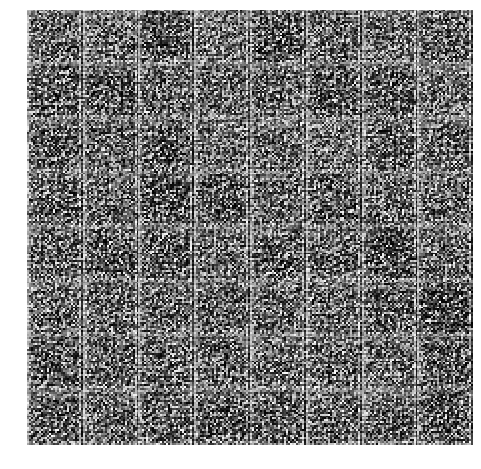

root        : INFO     0 [D loss: 0.07569414377212524, acc.: 39.062500] [G loss: -0.7524373531341553]


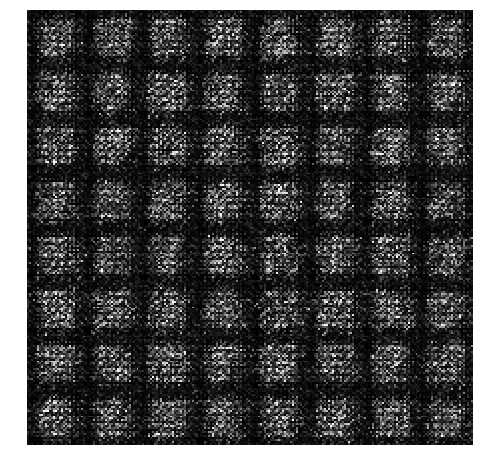

root        : INFO     100 [D loss: -0.40922242403030396, acc.: 0.000000] [G loss: -0.08477404713630676]


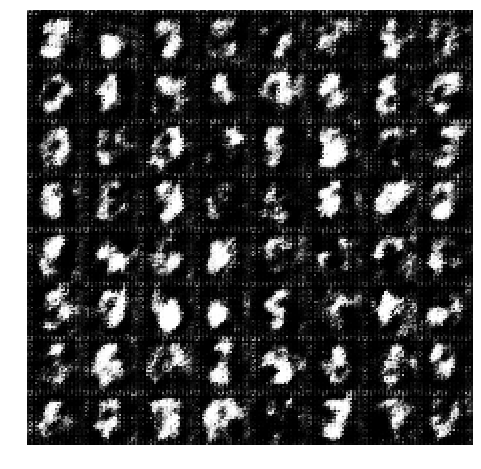

root        : INFO     200 [D loss: -0.09898313879966736, acc.: 25.000000] [G loss: -0.5113896727561951]


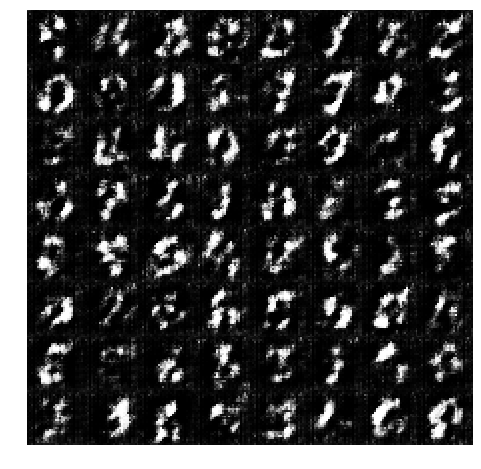

root        : INFO     300 [D loss: -0.1762930154800415, acc.: 18.750000] [G loss: -0.5398516654968262]


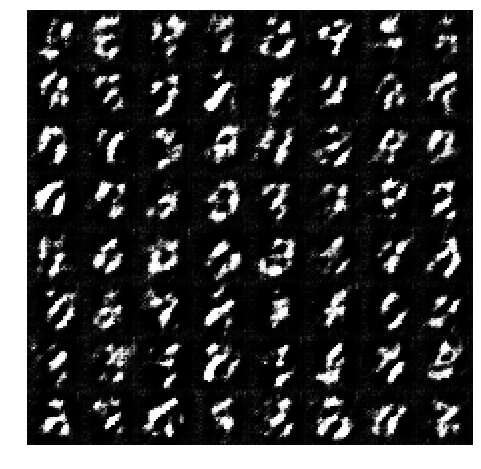

root        : INFO     400 [D loss: -0.08620814979076385, acc.: 10.937500] [G loss: -0.2331353724002838]


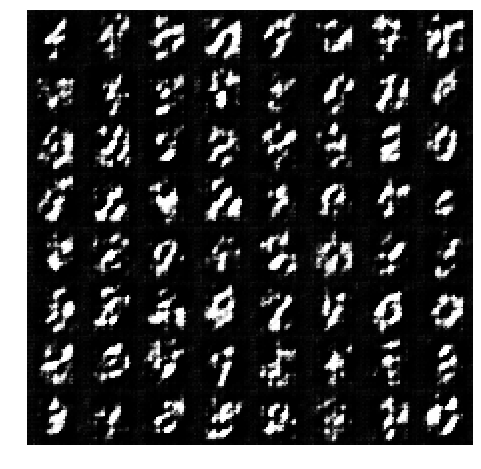

root        : INFO     500 [D loss: -0.039109885692596436, acc.: 10.937500] [G loss: -0.2722943127155304]


In [5]:
if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(iterations=params['iterations'], batch_size=params['batch_size'], save_interval=params['save_interval'])